## 1. Introduction to RLHF and trlX
Implementing RLHF with custom datasets can be a daunting task for those unfamiliar with the necessary tools and techniques. The primary objective of this notebook is to showcase a technique for reducing bias when fine-tuning Language Models (LLMs) using feedback from humans. To achieve this goal, we will be using a minimal set of tools, including Huggingface, GPT2, Label Studio, Weights and Biases, and trlX.

Our aim is to provide the most efficient and straightforward method for creating a pipeline that moves from raw data to a real-world RLHF system. We will walk through the process step-by-step, including an introduction to RLHF and trlX, setting up the environment, creating a custom dataset, labeling our dataset with Label Studio, training a preference model with our custom dataset, and finally, tuning our language model with our preference model using trlX.

Training Approach for RLHF ([source](https://arxiv.org/pdf/2009.01325.pdf)): 
1. Collect human feedback 
2. Train a reward model
3. Optimize LLM against the reward model


## 2. Setting up the environment and installing necessary libraries

In [ ]:
!git clone https://github.com/CarperAI/trlx.git
!git config --global --add safe.directory /content/trlx && cd /content/trlx && pip install -e .

In [ ]:
# uninstall scikit_learn + jax to avoid numpy issues
!pip uninstall -y scikit_learn jax

In [3]:
import os

# run within repo
os.chdir('/content/trlx/examples/summarize_rlhf/')
print(os.getcwd())

/content/trlx/examples/summarize_rlhf


In [ ]:
!pip install -r requirements.txt
!pip install mpi4py

In [19]:
# run within reward model directory
os.chdir('/content/trlx/examples/summarize_rlhf/reward_model/')
print(os.getcwd())

/content/trlx/examples/summarize_rlhf/reward_model


## 3. Creating a custom dataset 
In this section we will create a custom dataset for training our reward model. In the case of fine-tuning a LLM for human preference, our data tends to look like this: 

```json
{
    "prompt": "The quick brown fox...",
    "selection_1": "jumps over the lazy dog.",
    "selection_2": "bags few lynx.",
}
```

The labeler will provide feedback on which selection is preferred, given the prompt. This is the human feedback that will be incorporated into the system. This ranking by human labelers provides allows us to learn a model that scores the quality of our language model's responses.  

In this example, we'll show you how to create your own dataset. We'll start with a set of prompts, generate predictions for them using GPT-2, and then have users rank the predictions generated. 

Note: Due to the compute limitations of colab, we'll be using GPT-2 for this notebook. Thus, the quality of our predictions will not refelect much quality. If you have access to more hardware, then you can swap the GPT-2 model with a larger one like [GPT-J](https://huggingface.co/EleutherAI/gpt-j-6b) or others. 

In [6]:
from transformers import pipeline, set_seed
import json

def generate_text(prompt_list, model_name='gpt2', max_length=50, num_return_sequences=2, seed=42):
    generator = pipeline('text-generation', model=model_name)
    set_seed(seed)
    results = []
    for prompt in prompt_list:
        result = generator(prompt, max_length=max_length, num_return_sequences=num_return_sequences)
        results.append([res['generated_text'].strip() for res in result])
    return results

In [7]:
prompts = [
    "What is the latest news on the stock market?",
    "What is the current state of the economy?",
    "What are the latest developments in technology?",
    "What is the political situation in the Middle East?",
    "What are the latest trends in fashion and beauty?",
    "What are the top travel destinations for this year?",
    "What are some healthy recipes for a vegan diet?",
    "What are the most important events happening in the world today?",
    "What are some tips for improving mental health?",
    "What are the best ways to save money for retirement?",
    "What are some popular new books or movies?",
    "What are some effective ways to reduce stress?",
    "What are the latest developments in artificial intelligence?",
    "What are some top-rated restaurants in your city?",
    "What are the best ways to stay fit and healthy?",
    "What are some tips for successful entrepreneurship?",
    "What are some effective ways to improve productivity?",
    "What are the latest developments in climate change research?",
    "What are some top-rated TV shows or movies on streaming services?",
    "What are some fun activities to do on weekends?",
    "What are some effective ways to manage time and prioritize tasks?",
    "What are the latest trends in home decor and design?",
    "What are the best ways to develop a successful career?",
    "What are some popular new products or gadgets?",
    "What are some effective ways to improve communication skills?",
    "What are some tips for successful relationships?",
    "What are the latest developments in space exploration?",
    "What are some top-rated online courses or certifications?",
    "What are some effective ways to improve public speaking skills?",
    "What are the latest trends in digital marketing?",
    "What are some fun and creative DIY projects?",
    "What are some effective ways to improve leadership skills?"
]

In [ ]:
generated_text = generate_text(prompts)
print(generated_text)

In [ ]:
def to_pairwise_format(prompts, generated_texts):
    data = []
    for i, (prompt, generated_text) in enumerate(zip(prompts, generated_texts)):
        data.append({
            'id': i+1,
            'data': {
                'prompt': prompt,
                'answer1': generated_text[0],
                'answer2': generated_text[1]
            }
        })
    return data

In [ ]:
ls_data = to_pairwise_format(prompts, generated_text)

In [ ]:
# Save our data to a json file
with open('ls_input_data.json', 'w') as f:
    json.dump(ls_data, f)

# 4. Labeling our dataset with Label Studio

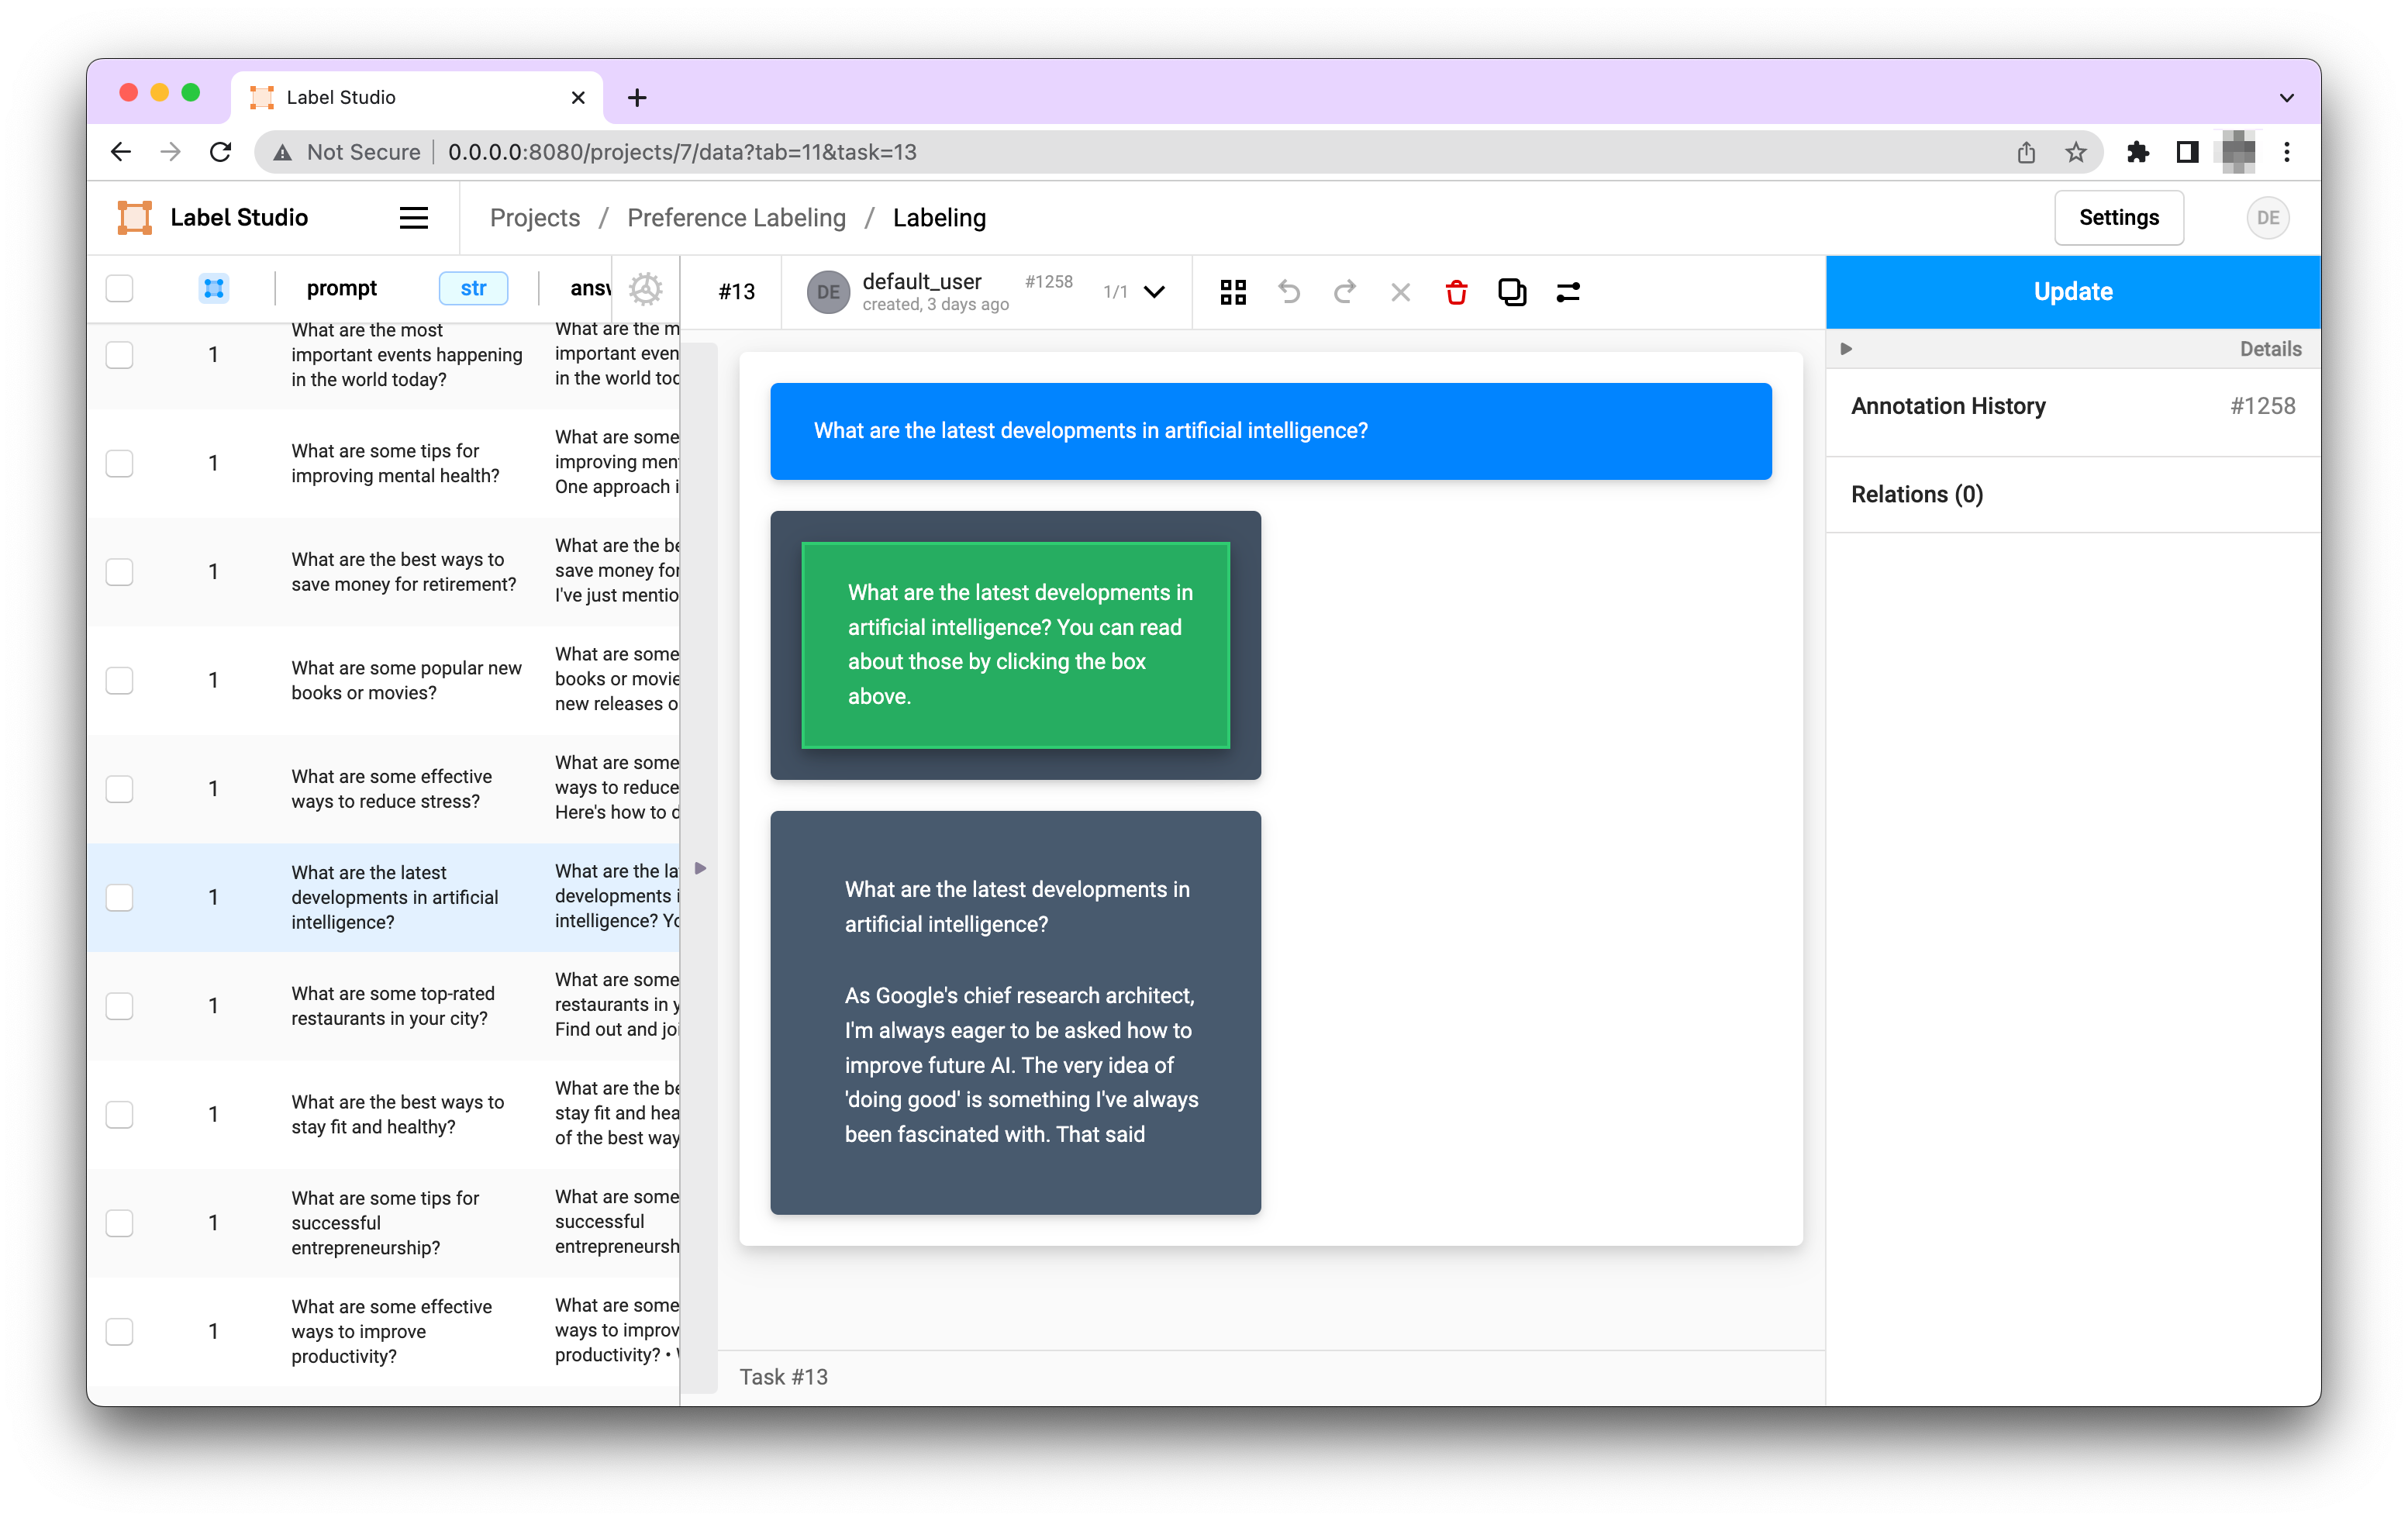

Now that we have generated some examples, we will label them in Label Studio. 
Once we have the results of our human labels, we can export the data and train our Preference Model. 

1. First, we can start Label Studio following the instructions [here](https://labelstud.io/guide/install.html). 

2. Once we have label studio running, we can create a new project with the [Pariwise Classification template](https://labelstud.io/templates/pairwise_comparison.html). The templates themselves are really flexible, so we'll do some minor edits to make it look a little nicer. The configuration for this template is shown below. 

```xml
<?xml version="1.0" encoding="UTF-8"?>
<View>
   <Style>* { box-sizing: border-box; margin: 0; padding: 0; } body { font-family: 'Roboto', sans-serif; line-height: 1.6; background-color: #f0f0f0; } .container { margin: 0 auto; padding: 20px; background-color: #ffffff; border-radius: 5px; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.1), 0 6px 20px 0 rgba(0, 0, 0, 0.1); } .prompt { padding: 20px; background-color: #0084ff; color: #ffffff; border-radius: 5px; margin-bottom: 20px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1), 0 3px 10px 0 rgba(0, 0, 0, 0.1); } .answers { display: flex; justify-content: space-between; flex-wrap: wrap; gap: 20px; } .answer-box { flex-basis: 49%; padding: 20px; background-color: rgba(44, 62, 80, 0.9); color: #ffffff; border-radius: 5px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1), 0 3px 10px 0 rgba(0, 0, 0, 0.1); } .answer-box p { word-wrap: break-word; } .answer-box:hover { background-color: rgba(52, 73, 94, 0.9); cursor: pointer; transition: all 0.3s ease; } .lsf-richtext__line:hover { background: unset; } .answer-box .lsf-object { padding: 20px }</Style>
   <View className="container">
      <View className="prompt">
         <Text name="prompt" value="$prompt" />
      </View>
      <View className="answers">
         <Pairwise name="pw" toName="answer1,answer2" selectionStyle="background-color: #27ae60; box-shadow: 0 4px 8px 0 rgba(0, 0, 0, 0.2), 0 6px 20px 0 rgba(0, 0, 0, 0.2); border: 2px solid #2ecc71; cursor: pointer; transition: all 0.3s ease;" />
         <View className="answer-box">
            <Text name="answer1" value="$answer1" />
         </View>
         <View className="answer-box">
            <Text name="answer2" value="$answer2" />
         </View>
      </View>
   </View>
</View>
```

3. Next we'll drag and drop to upload our data, and we're off! 

4. Once we're finished labeling our data, we can export it and we're ready to train our preference model. 

Note: If you're using colab, upload the dataset into the root directory, and your file will be located at a path in `/content/...`, like `/content/project-7-at-2023-04-12-22-24-4c78f924.json`.

## 5. Training a preference model with our custom dataset
Now we're ready to train our preference model. We'll create a dataset from our labels, initialize our model from the pretrained LM, and then begin training. 

When we finally train our model, we can connect with Weights and Biases to log our training metrics. 

In [ ]:
# # Example Label Studio Output if we skip the human labeling
# with open('/content/project-7-at-2023-04-12-22-24-4c78f924.json', 'r') as f:
#   data = json.load(f)

In [20]:
import os

import torch
from datasets import load_dataset
from reward_model import GPTRewardModel
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import AutoTokenizer, Trainer, TrainingArguments

def create_comparison_dataset_ls(path: str):
    with open(path, "r") as f:
        data = json.load(f)
    pairs = []
    for sample in data:
        chosen = None
        rejected = None
        for annotation in sample['annotations']:
            if annotation['result'][0]['value']['selected'] == 'left':
                chosen = sample['data']['prompt'] + '\n' + sample['data']['answer1']
                rejected = sample['data']['prompt'] + '\n' + sample['data']['answer2']
            else:
                chosen = sample['data']['prompt'] + '\n' + sample['data']['answer2']
                rejected = sample['data']['prompt'] + '\n' + sample['data']['answer1']
            pair = {
                'chosen': chosen,
                'rejected': rejected
            }
            pairs.append(pair)
    return pairs

class PairwiseDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length):
        self.chosen_input_ids = []
        self.chosen_attn_masks = []
        self.rejected_input_ids = []
        self.rejected_attn_masks = []
        for pair in tqdm(pairs):
            chosen, rejected = pair["chosen"], pair["rejected"]
            chosen_encodings_dict = tokenizer(
                "<|startoftext|>" + chosen + "<|endoftext|>",
                truncation=True,
                max_length=max_length,
                padding="max_length",
                return_tensors="pt",
            )
            rejected_encodings_dict = tokenizer(
                "<|startoftext|>" + rejected + "<|endoftext|>",
                truncation=True,
                max_length=max_length,
                padding="max_length",
                return_tensors="pt",
            )
            self.chosen_input_ids.append(chosen_encodings_dict["input_ids"])
            self.chosen_attn_masks.append(chosen_encodings_dict["attention_mask"])
            self.rejected_input_ids.append(rejected_encodings_dict["input_ids"])
            self.rejected_attn_masks.append(rejected_encodings_dict["attention_mask"])

    def __len__(self):
        return len(self.chosen_input_ids)

    def __getitem__(self, idx):
        return (
            self.chosen_input_ids[idx],
            self.chosen_attn_masks[idx],
            self.rejected_input_ids[idx],
            self.rejected_attn_masks[idx],
        )


class DataCollatorReward:
    def __call__(self, data):
        batch = {}
        batch["input_ids"] = torch.cat([f[0] for f in data] + [f[2] for f in data])
        batch["attention_mask"] = torch.cat([f[1] for f in data] + [f[3] for f in data])
        batch["labels"] = torch.tensor([0] * len(data) + [1] * len(data))
        return batch


def compute_metrics(eval_preds):
    chosen_end_scores = eval_preds.predictions[0]  # chosen scores
    rejected_end_scores = eval_preds.predictions[1]  # rejected scores

    result = {}
    acc = sum(chosen_end_scores > rejected_end_scores) / len(rejected_end_scores)
    result["accuracy"] = acc

    return result


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

if not os.path.exists("rm_checkpoint"):
    os.mkdir("rm_checkpoint")

# Initialize the reward model from the GPT-2 model (optionally SFT GPT-2)
model = GPTRewardModel("gpt2")

# Freeze the first 70% of the hidden layers of the reward model backbone
layers = model.transformer.h
num_layers = len(layers)
num_unfrozen = int(0.3 * num_layers)
for layer in layers[:-num_unfrozen]:
    layer.requires_grad_(False)

# Create the comparisons datasets
data_path = "/content/project-7-at-2023-04-12-23-04-c1e74664.json"
pairs = create_comparison_dataset_ls(data_path)
train_size = int(0.8 * len(pairs))  # 80% training, 20% validation
train_pairs = pairs[0:train_size]
val_pairs = pairs[train_size:]


# Make pairwise datasets for training
max_length = 550
train_dataset = PairwiseDataset(train_pairs, tokenizer, max_length=max_length)
val_dataset = PairwiseDataset(val_pairs, tokenizer, max_length=max_length)

# Create the collator to gather batches of pairwise comparisons
data_collator = DataCollatorReward()

In [12]:
training_args = TrainingArguments(
    output_dir="rm_checkpoint/",
    num_train_epochs=50,
    logging_steps=10,
    gradient_accumulation_steps=4,
    save_strategy="steps",
    evaluation_strategy="steps",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_accumulation_steps=1,
    eval_steps=10,
    save_steps=10,
    warmup_steps=100,
    logging_dir="./logs",
    fp16=True,
    bf16=False,
    learning_rate=1e-5,
    # deepspeed="ds_config_gpt_j.json",
    save_total_limit=1
)

Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
    eval_dataset=val_dataset,
    data_collator=data_collator,
).train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=50, training_loss=0.9457474708557129, metrics={'train_runtime': 96.6809, 'train_samples_per_second': 12.929, 'train_steps_per_second': 0.517, 'total_flos': 0.0, 'train_loss': 0.9457474708557129, 'epoch': 28.57})

## 6. Tune language model using PPO with our preference model


Once we have our reward model, we can traing our model using PPO. We can find more details about this setup with the trlX libarary [here](https://github.com/CarperAI/trlx/tree/main/examples/summarize_rlhf). 

```
accelerate launch --config_file configs/default_accelerate_config.yaml trlx_gptj_text_summarization.py
```

Note: Due to [limitations in the trlX library](https://github.com/CarperAI/trlx/issues/211), training the language model cannot be performed in a Colab environment. 

In [5]:
# chang to summarize example directory
os.chdir('/content/trlx/examples/summarize_rlhf/')
print(os.getcwd())

/content/trlx/examples/summarize_rlhf


In [6]:
import os
from typing import List

import torch
from datasets import load_dataset
from reward_model.reward_model import GPTRewardModel
from tqdm import tqdm
from transformers import AutoTokenizer

import trlx
from trlx.data.configs import (
    ModelConfig,
    OptimizerConfig,
    SchedulerConfig,
    TokenizerConfig,
    TrainConfig,
    TRLConfig,
)
from trlx.models.modeling_ppo import PPOConfig

In [ ]:
REWARD_CHECKPOINT_PATH = "reward_model/rm_checkpoint/checkpoint-50/pytorch_model.bin"
SFT_MODEL_PATH = "gpt2"

config = TRLConfig(
    train=TrainConfig(
        seq_length=550,
        epochs=50,
        total_steps=100000,
        batch_size=4,
        checkpoint_interval=10000,
        eval_interval=200,
        pipeline="PromptPipeline",
        trainer="AcceleratePPOTrainer",
    ),
    model=ModelConfig(
        model_path="gpt2",
        num_layers_unfrozen=8,
    ),
    tokenizer=TokenizerConfig(
        tokenizer_path="gpt2",
        truncation_side="right",
    ),
    optimizer=OptimizerConfig(
        name="adamw",
        kwargs={
            "lr": 5.0e-6,
            "betas": [0.9, 0.999],
            "eps": 1.0e-8,
            "weight_decay": 0.01,
        },
    ),
    scheduler=SchedulerConfig(
        name="cosine_annealing",
        kwargs={
            "T_max": 100000,
            "eta_min": 5.0e-6,
        },
    ),
    method=PPOConfig(
        name="PPOConfig",
        num_rollouts=128,
        chunk_size=16,
        ppo_epochs=4,
        init_kl_coef=0.1,
        target=6,
        horizon=10000,
        gamma=1,
        lam=0.95,
        cliprange=0.2,
        cliprange_value=0.2,
        vf_coef=0.2,
        scale_reward=None,
        ref_mean=None,
        ref_std=None,
        cliprange_reward=10,
        gen_kwargs={
            "max_new_tokens": 50,
        },
    ),
)


# Load the pre-trained reward model
rw_tokenizer = AutoTokenizer.from_pretrained("gpt2")
rw_tokenizer.pad_token = rw_tokenizer.eos_token
rw_model = GPTRewardModel(SFT_MODEL_PATH)
rw_model.load_state_dict(torch.load(REWARD_CHECKPOINT_PATH))
rw_model.half()
rw_model.eval()
# rw_device = torch.device("cuda:{}".format(1))  # set reward model device
# rw_model.to(rw_device)

def get_scores(samples: List[str]):
    scores_list = []
    batch_size = 2
    for i in range(0, len(samples), batch_size):
        sub_samples = samples[i : i + batch_size]
        sub_samples = ["<|startoftext|>" + chosen + "<|endoftext|>" for chosen in sub_samples]
        encodings_dict = rw_tokenizer(
            sub_samples,
            truncation=True,
            max_length=config.train.seq_length,
            padding="max_length",
            return_tensors="pt",
        )
        input_ids = encodings_dict["input_ids"].to(rw_device)
        attn_masks = encodings_dict["attention_mask"].to(rw_device)
        input_ids = input_ids.repeat(2, 1)
        attn_masks = attn_masks.repeat(2, 1)
        with torch.no_grad():
            sub_scores = rw_model(input_ids=input_ids, attention_mask=attn_masks)
        scores_list.append(sub_scores["chosen_end_scores"])
    scores = torch.cat(scores_list, dim=0)
    return scores

def get_prompt_dataset(prompts, max_length):
    """
    Get the prompt after T5 decoding to make sure dictionary
    of prompts and summaries is consistent decode prompt from trlX pipeline
    """
    formatted_prompts = []
    for i in tqdm(range(len(prompts))):
        tmp = tokenizer.decode(
            tokenizer(
                prompts[i].split("TL;DR:")[0],
                truncation=True,
                max_length=max_length - 5,  # to make sure "TL;DR" dont get truncated
                add_special_tokens=False,
            )["input_ids"],
            skip_special_tokens=True,
        ).strip()
        tmp = tmp + "\nTL;DR:"
        tmp = tokenizer.decode(
            tokenizer(tmp, truncation=True, max_length=max_length, add_special_tokens=False)["input_ids"],
            skip_special_tokens=True,
        ).strip()
        formatted_prompts.append(tmp)
    return formatted_prompts

def reward_fn(samples: List[str], **kwargs):
    original_samples = [text.split("TL;DR:")[0] + "TL;DR: " for text in samples]
    original_samples = [text + post_summary_dict[text.strip()] for text in original_samples]
    original_scores = get_scores(original_samples)
    scores = get_scores(samples)
    norms_scores = scores - original_scores
    return norms_scores

tokenizer = AutoTokenizer.from_pretrained(config.tokenizer.tokenizer_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
max_length_input = config.train.seq_length - config.method.gen_kwargs["max_new_tokens"]

dataset = load_dataset("CarperAI/openai_summarize_tldr")

# Store data into prompt and label pairs
train_set = [(sample["prompt"], sample["label"]) for sample in dataset["train"]]
val_set = [(sample["prompt"], sample["label"]) for sample in dataset["valid"]]

# Split contents into summaries and labels
train_posts, train_summaries = zip(*train_set)
val_posts, val_summaries = zip(*val_set)

# Get the OpenAI summaries
post_summary_dict = {}
train_prompts = get_prompt_dataset(train_posts, max_length_input)
for i in range(len(train_prompts)):
    post_summary_dict[train_prompts[i]] = train_summaries[i]
val_prompts = get_prompt_dataset(val_posts, max_length_input)
for i in range(len(val_prompts)):
    post_summary_dict[val_prompts[i]] = val_summaries[i]


In [ ]:
trainer = trlx.train(
    reward_fn=reward_fn,
    prompts=train_prompts,
    eval_prompts=val_prompts[0:1000],  # sampling 1000 validation prompts for evaluation speed in training
    config=config,
)

## 7. References 
- [Implementing RLHF: Learning to Summarize with trlX](https://wandb.ai/carperai/summarize_RLHF/reports/Implementing-RLHF-Learning-to-Summarize-with-trlX--VmlldzozMzAwODM2)

- [General overview about RLHF](https://huggingface.co/blog/rlhf)
- [Another end-to-end example with trlX](https://wandb.ai/carperai/summarize_RLHF/reports/Implementing-RLHF-Learning-to-Summarize-with-trlX--VmlldzozMzAwODM2)
- [Similar human-in-the-loop annotation framework](https://github.com/CarperAI/cheese/tree/main/examples)
- [Antropic harmless RLHF paper](https://arxiv.org/pdf/2204.05862.pdf) and [blog about CAI general principles](https://lifearchitect.ai/anthropic/)